In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
import utils
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sqlalchemy import text

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# OsloMod report plots

Notebook creating visualisations for the terrestrial modelling chapter of the OsloMod report.

## 1. How typical is 2017 - 2019?

### 1.1. Runoff

In [4]:
of_area_km2 = 84992.3
sql = (
    'SELECT date, SUM("flow_m3/s") AS flow_m3ps '
    "FROM teotil3.nve_hbv_discharge "
    "WHERE data_supply_year = 2025 "
    "AND vassom::INTEGER <= 17 "
    "GROUP BY date"
)
df = pd.read_sql(sql, eng)
df["year"] = df["date"].dt.year
df["vol_m3"] = df["flow_m3ps"] * 60 * 60 * 24
df["runoff_mm"] = 1000 * df["vol_m3"] / (of_area_km2 * 1e6)
df = df[["year", "runoff_mm"]].groupby("year").sum().reset_index()
df.head()

,year,runoff_mm
0,1990,549.732770
1,1991,414.601632
2,1992,448.130015
3,1993,544.647346
4,1994,583.753812


Mean runoff 1991-2020: 541.5 mm.
Mean runoff 2017-2019: 541.7 mm.


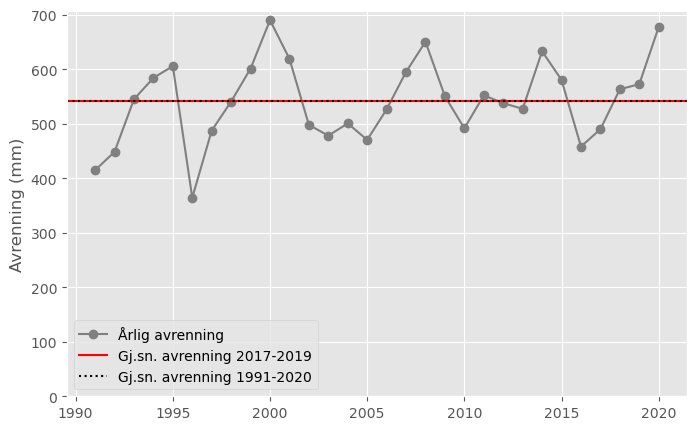

In [5]:
base_st, base_end = 1991, 2020
mod_st, mod_end = 2017, 2019

base_df = df.query("@base_st <= year <= @base_end").copy()
base = base_df["runoff_mm"].mean()
mod_df = df.query("@mod_st <= year <= @mod_end").copy()
mod = mod_df["runoff_mm"].mean()

print(f"Mean runoff {base_st}-{base_end}: {base:.1f} mm.")
print(f"Mean runoff {mod_st}-{mod_end}: {mod:.1f} mm.")

ax = base_df.plot(
    x="year",
    y="runoff_mm",
    c="gray",
    marker="o",
    legend=False,
    label="Årlig avrenning",
    figsize=(8, 5),
)
ax.axhline(
    y=mod, color="red", linestyle="-", label=f"Gj.sn. avrenning {mod_st}-{mod_end}"
)
ax.axhline(
    y=base, color="k", linestyle=":", label=f"Gj.sn. avrenning {base_st}-{base_end}"
)
ax.set_ylabel("Avrenning (mm)")
ax.set_xlabel("")
ax.set_ylim(bottom=0)
ax.legend()

plt.savefig(r"../plots/oslofjord_mean_runoff.png", dpi=200, bbox_inches="tight")

### 1.2. Nutrient inputs

In [6]:
base_st, base_end = 2013, 2022
mod_st, mod_end = 2017, 2019

Mean 2013-2022:


year             2017.500000
totn_tonnes     36391.748682
totp_tonnes       918.520902
toc_tonnes     225026.035404
ss_tonnes      342847.750790
dtype: float64

Mean runoff 2017-2019:


year             2018.000000
totn_tonnes     37860.207513
totp_tonnes       918.506731
toc_tonnes     223892.589889
ss_tonnes      344446.888984
dtype: float64

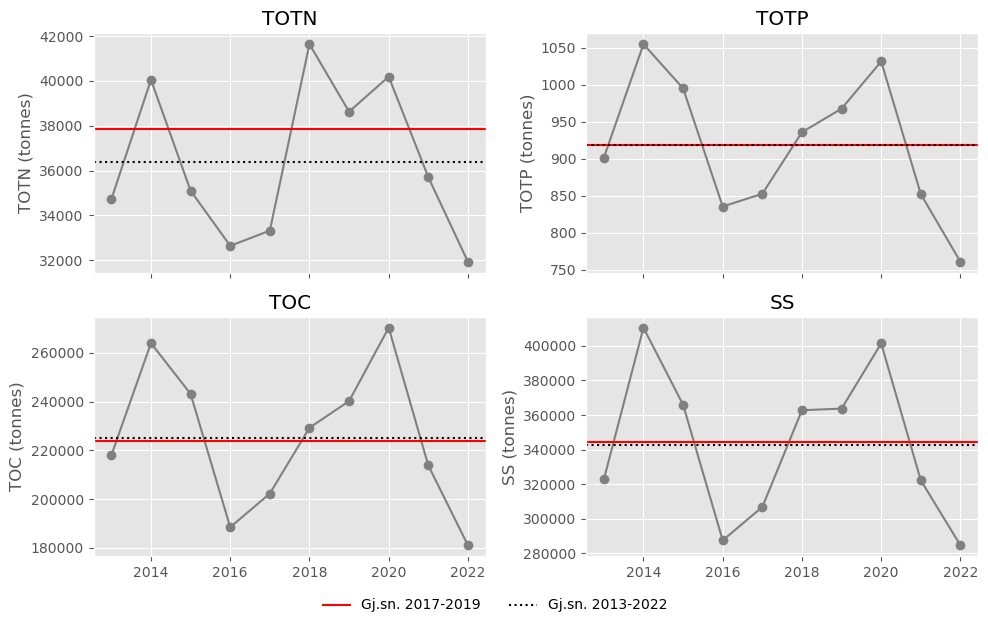

In [7]:
csv_path = r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2024_2013-2023_agri-annual-loss.csv"
vassom_list = [f"{i:03d}." for i in range(1, 18)]
df = pd.read_csv(csv_path).query("regine in @vassom_list")
cols = ["year"] + [col for col in df.columns if col.startswith("accum_")]
df = df[cols].groupby("year").sum().reset_index()

pars = ["totn", "totp", "toc", "ss"]
for par in pars:
    par_cols = [col for col in df.columns if f"_{par}_" in col]
    df[f"{par}_tonnes"] = df[par_cols].sum(axis="columns") / 1000

cols = [col for col in df.columns if col.endswith("_tonnes")]
df = df[["year"] + cols]

base_df = df.query("@base_st <= year <= @base_end").copy()
mod_df = df.query("@mod_st <= year <= @mod_end").copy()

print(f"Mean {base_st}-{base_end}:")
display(base_df.mean())
print(f"Mean runoff {mod_st}-{mod_end}:")
display(mod_df.mean())

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(10, 6))
axes = axes.flatten()
for idx, par in enumerate(pars):
    base = base_df[f"{par}_tonnes"].mean()
    mod = mod_df[f"{par}_tonnes"].mean()
    base_df.plot(
        x="year",
        y=f"{par}_tonnes",
        c="gray",
        marker="o",
        ax=axes[idx],
        # label=f"Årlig {par.upper()}",
        legend=False,
        label="",
    )
    axes[idx].axhline(
        y=mod, color="red", linestyle="-", label=f"Gj.sn. {mod_st}-{mod_end}"
    )
    axes[idx].axhline(
        y=base, color="k", linestyle=":", label=f"Gj.sn. {base_st}-{base_end}"
    )
    axes[idx].set_ylabel(f"{par.upper()} (tonnes)")
    axes[idx].set_xlabel("")
    axes[idx].set_title(par.upper())
    # axes[idx].legend()

# Only add legend for the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.05),
    frameon=False,
)

plt.tight_layout()

plt.savefig(r"../plots/teotil3_oslofjord_mean_inputs.png", dpi=200, bbox_inches="tight")

## 2. Baseline source apportionment

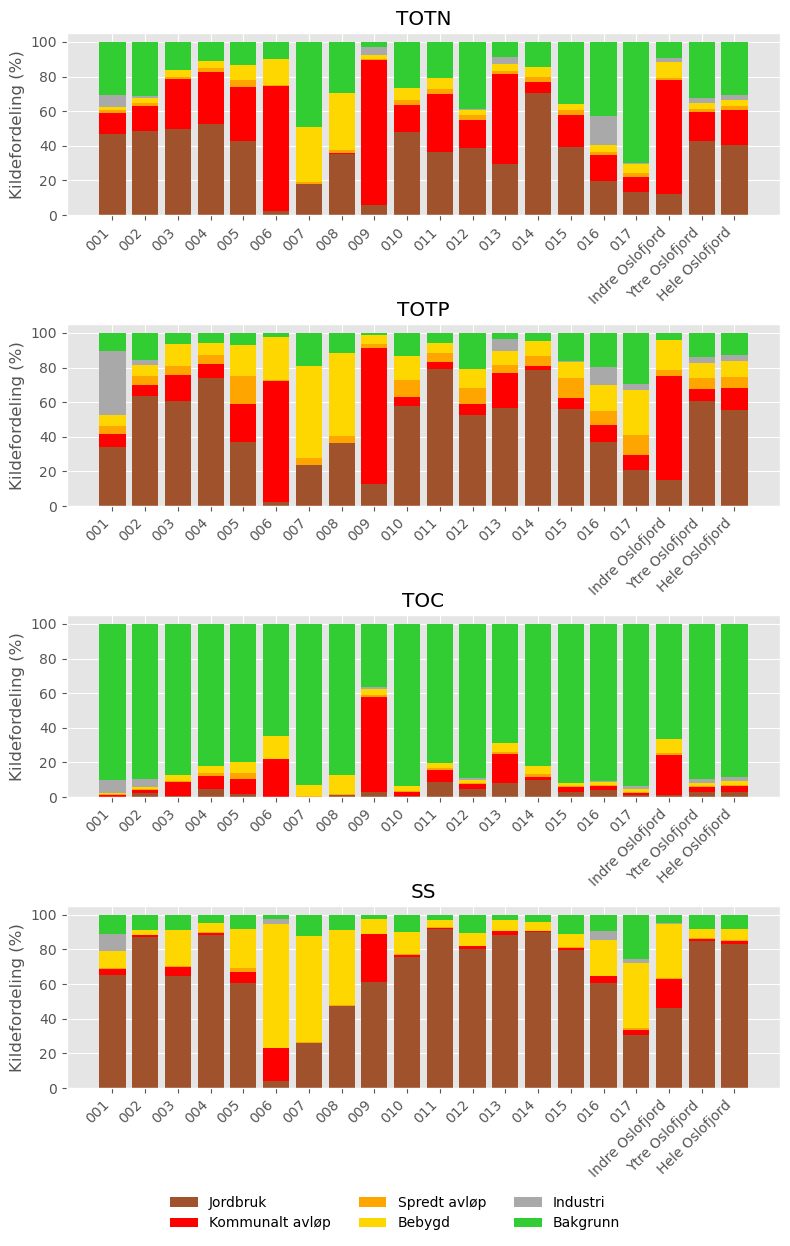

In [8]:
pars = ["TOTN", "TOTP", "TOC", "SS"]
colour_dict = {
    "Akvakultur": "royalblue",
    "Jordbruk": "sienna",
    "Kommunalt avløp": "red",
    "Spredt avløp": "orange",
    "Industri": "darkgrey",
    "Bebygd": "gold",
    "Bakgrunn": "limegreen",
}
source_order = [
    "Jordbruk",
    "Kommunalt avløp",
    "Spredt avløp",
    "Bebygd",
    "Industri",
    "Akvakultur",
    "Bakgrunn",
]
xorder = [f"{i:03d}" for i in range(1, 18)] + [
    "Indre Oslofjord",
    "Ytre Oslofjord",
    "Hele Oslofjord",
]

# Load and filter data
csv_path = r"../data/results_summary.csv"
df = pd.read_csv(csv_path)
df = df.query("(Scenario == 'Baseline') and (Parameter in @pars)").copy()

# Ignore aquaculture, as negligible around OF
df = df.query("Kilde != 'Akvakultur'")

src_list = df["Kilde"].unique().tolist()
source_order = [src for src in source_order if src in src_list]


def prepare_data(df, parameter):
    df_param = df[df["Parameter"] == parameter]
    pivot = df_param.pivot_table(
        index="Område",
        columns="Kilde",
        values="Verdi (tonn)",
        aggfunc="sum",
        fill_value=0,
    )
    cols = [col for col in source_order if col in pivot.columns]
    pivot = pivot[cols]
    percent = pivot.div(pivot.sum(axis=1), axis=0) * 100
    return percent


# Create subplots
num_params = len(pars)
fig, axes = plt.subplots(num_params, 1, figsize=(8, 3 * num_params), sharex=False)

# Loop through each parameter and plot in subplot
for i, parameter in enumerate(pars):
    percent = prepare_data(df, parameter)
    percent = percent.reindex(xorder)
    cols = [col for col in percent.columns if col in source_order]
    ax = axes[i] if num_params > 1 else axes  # Handle single subplot case
    bottom = pd.Series([0] * len(percent), index=percent.index)
    for source in cols:
        ax.bar(
            percent.index,
            percent[source],
            bottom=bottom,
            color=colour_dict[source],
            label=source,
        )
        # if source == "Bakgrunn":
        #     ax.bar(
        #         percent.index,
        #         [1] * len(percent),
        #         bottom=bottom,
        #         color="black",
        #         linewidth=0,
        #         facecolor="black",
        #         zorder=1000,
        #     )
        bottom += percent[source]

    ax.set_title(parameter)
    ax.set_ylabel("Kildefordeling (%)")
    ax.set_xlabel("")
    # ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Only add legend for the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.04),
    frameon=False,
)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.savefig(r"../plots/baseline_source_apportionment.png", dpi=200, bbox_inches="tight")

In [9]:
areas = ["Indre Oslofjord", "Ytre Oslofjord", "Hele Oslofjord"]
src_order = [
    "Jordbruk",
    "Kommunalt avløp",
    "Spredt avløp",
    "Bebygd",
    "Industri",
    "Bakgrunn",
]

pct_of_anthrop = True

for area in areas:
    for par in pars:
        df2 = df.query("(Område == @area) and (Parameter == @par)").copy()
        if pct_of_anthrop:
            df2 = df2.query("Kilde != 'Bakgrunn'")
        df2["pct_contrib"] = 100 * df2["Verdi (tonn)"] / df2["Verdi (tonn)"].sum()
        df2["pct_contrib"] = df2["pct_contrib"].round(1)
        df2 = (
            df2[["Kilde", "Parameter", "pct_contrib"]]
            .set_index("Kilde")
            .reindex(src_order)
        )
        print("####################################")
        print(area, par)
        display(df2)

####################################
Indre Oslofjord TOTN


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTN,13.8
Kommunalt avløp,TOTN,72.2
Spredt avløp,TOTN,1.3
Bebygd,TOTN,10.4
Industri,TOTN,2.5
Bakgrunn,NaN,NaN


####################################
Indre Oslofjord TOTP


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTP,15.9
Kommunalt avløp,TOTP,62.2
Spredt avløp,TOTP,3.7
Bebygd,TOTP,18.2
Industri,NaN,NaN
Bakgrunn,NaN,NaN


####################################
Indre Oslofjord TOC


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOC,4.0
Kommunalt avløp,TOC,68.7
Spredt avløp,TOC,2.8
Bebygd,TOC,23.1
Industri,TOC,1.4
Bakgrunn,NaN,NaN


####################################
Indre Oslofjord SS


,Parameter,pct_contrib
Kilde,,
Jordbruk,SS,48.8
Kommunalt avløp,SS,17.5
Spredt avløp,SS,0.6
Bebygd,SS,32.6
Industri,SS,0.5
Bakgrunn,NaN,NaN


####################################
Ytre Oslofjord TOTN


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTN,63.6
Kommunalt avløp,TOTN,24.5
Spredt avløp,TOTN,3.0
Bebygd,TOTN,4.9
Industri,TOTN,4.0
Bakgrunn,NaN,NaN


####################################
Ytre Oslofjord TOTP


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTP,70.3
Kommunalt avløp,TOTP,8.4
Spredt avløp,TOTP,7.5
Bebygd,TOTP,9.7
Industri,TOTP,4.1
Bakgrunn,NaN,NaN


####################################
Ytre Oslofjord TOC


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOC,29.5
Kommunalt avløp,TOC,23.2
Spredt avløp,TOC,7.1
Bebygd,TOC,14.9
Industri,TOC,25.4
Bakgrunn,NaN,NaN


####################################
Ytre Oslofjord SS


,Parameter,pct_contrib
Kilde,,
Jordbruk,SS,92.5
Kommunalt avløp,SS,1.1
Spredt avløp,SS,0.3
Bebygd,SS,5.7
Industri,SS,0.4
Bakgrunn,NaN,NaN


####################################
Hele Oslofjord TOTN


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTN,59.0
Kommunalt avløp,TOTN,28.9
Spredt avløp,TOTN,2.8
Bebygd,TOTN,5.4
Industri,TOTN,3.8
Bakgrunn,NaN,NaN


####################################
Hele Oslofjord TOTP


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOTP,64.0
Kommunalt avløp,TOTP,14.7
Spredt avløp,TOTP,7.0
Bebygd,TOTP,10.7
Industri,TOTP,3.6
Bakgrunn,NaN,NaN


####################################
Hele Oslofjord TOC


,Parameter,pct_contrib
Kilde,,
Jordbruk,TOC,26.0
Kommunalt avløp,TOC,29.4
Spredt avløp,TOC,6.5
Bebygd,TOC,16.0
Industri,TOC,22.1
Bakgrunn,NaN,NaN


####################################
Hele Oslofjord SS


,Parameter,pct_contrib
Kilde,,
Jordbruk,SS,90.3
Kommunalt avløp,SS,1.9
Spredt avløp,SS,0.3
Bebygd,SS,7.0
Industri,SS,0.4
Bakgrunn,NaN,NaN


## 3. Regine maps

Changes achieved by each scenario in each regine by agricultural and wastewater measures, relative to the anthropogenic baseline.

In [10]:
reg_gdf = teo.io.get_regine_geodataframe(eng, 2023)

In [11]:
scens = ["Baseline", "Scenario_A", "Scenario_B"]
years = range(2017, 2020)
base_dir = r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_input_files"
df_list = []
for scen in scens:
    for year in years:
        fname = f"oslomod_teotil3_input_data_{scen.lower()}_{year}.csv"
        csv_path = os.path.join(base_dir, scen, fname)
        df = pd.read_csv(csv_path)
        df["scenario"] = scen
        df["year"] = year
        df_list.append(df)
df = pd.concat(df_list, axis="rows")

cols = ["regine", "scenario", "year"] + [
    col for col in df.columns if col.endswith("_kg")
]
df = df[cols]
df = df.melt(id_vars=["regine", "scenario", "year"])
df[["source", "par", "unit"]] = df["variable"].str.split("_", expand=True)
del df["variable"], df["unit"]

anth_srcs = [
    "urban",
    "spredt",
    "aquaculture",
    "industry",
    "agriculture",
    "large-wastewater",
]
df = df.query("source in @anth_srcs")

df_all = df.groupby(["regine", "scenario", "par"]).sum()["value"].reset_index()
df_all["source"] = "Menneskeskapt"
df_ww = (
    df.query("source == 'large-wastewater'")
    .groupby(["regine", "scenario", "par"])
    .sum()["value"]
    .reset_index()
)
df_ww["source"] = "Kommunalt avløp"
df_agri = (
    df.query("source == 'agriculture'")
    .groupby(["regine", "scenario", "par"])
    .sum()["value"]
    .reset_index()
)
df_agri["source"] = "Jordbruk"
df = pd.concat([df_all, df_ww, df_agri], axis="rows")

df.head()

,regine,scenario,par,value,source
0,001.,Baseline,din,0.0,Menneskeskapt
1,001.,Baseline,ss,0.0,Menneskeskapt
2,001.,Baseline,tdp,0.0,Menneskeskapt
3,001.,Baseline,toc,0.0,Menneskeskapt
4,001.,Baseline,ton,0.0,Menneskeskapt


In [12]:
pars = ["totn", "totp", "toc", "ss"]
sources = ["Jordbruk", "Kommunalt avløp"]
scens = ["Scenario_A", "Scenario_B"]

for scen in scens:
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 10))
    for col_idx, par in enumerate(pars):
        base_tot_df = (
            df.query(
                "(par == @par) and (scenario == 'Baseline') and (source == 'Menneskeskapt')"
            )[["regine", "value"]]
            .rename(columns={"value": "base_tot"})
            .set_index("regine")
        )
        base_agri_df = (
            df.query(
                "(par == @par) and (scenario == 'Baseline') and (source == 'Jordbruk')"
            )[["regine", "value"]]
            .rename(columns={"value": "base_agri"})
            .set_index("regine")
        )
        scen_agri_df = (
            df.query(
                "(par == @par) and (scenario == @scen) and (source == 'Jordbruk')"
            )[["regine", "value"]]
            .rename(columns={"value": "scen_agri"})
            .set_index("regine")
        )
        base_ww_df = (
            df.query(
                "(par == @par) and (scenario == 'Baseline') and (source == 'Kommunalt avløp')"
            )[["regine", "value"]]
            .rename(columns={"value": "base_ww"})
            .set_index("regine")
        )
        scen_ww_df = (
            df.query(
                "(par == @par) and (scenario == @scen) and (source == 'Kommunalt avløp')"
            )[["regine", "value"]]
            .rename(columns={"value": "scen_ww"})
            .set_index("regine")
        )

        par_df = pd.concat(
            [base_tot_df, base_agri_df, scen_agri_df, base_ww_df, scen_ww_df],
            axis="columns",
        )

        par_df["Jordbruk"] = (
            (100 * (par_df["scen_agri"] - par_df["base_agri"]) / par_df["base_tot"])
            .fillna(0)
            .abs()
        )
        par_df["Kommunalt avløp"] = (
            (100 * (par_df["scen_ww"] - par_df["base_ww"]) / par_df["base_tot"])
            .fillna(0)
            .abs()
        )

        par_df = par_df.reset_index()
        par_df[par_df == 0] = np.nan
        par_gdf = reg_gdf.merge(
            par_df[["regine", "Jordbruk", "Kommunalt avløp"]], how="inner", on="regine"
        )
        par_gdf["dissolve"] = 1
        cat_gdf = par_gdf.dissolve(by="dissolve")
        cat_gdf.geometry = cat_gdf.geometry.apply(
            lambda p: nivapy.spatial.remove_polygon_holes(p)
        )

        for row_idx, src in enumerate(["Jordbruk", "Kommunalt avløp"]):
            img = par_gdf.plot(
                ax=axes[row_idx, col_idx],
                column=src,
                cmap="YlOrRd",
                vmin=0,
                vmax=100,
                edgecolor="none",
                missing_kwds={"color": "none", "edgecolor": "none"},
            ).collections[0]

            if not ((par == "totp") and (src == "Kommunalt avløp")):
                cax = inset_axes(
                    axes[row_idx, col_idx],
                    width="5%",
                    height="30%",
                    loc="upper left",
                    bbox_to_anchor=(0.02, -0.05, 1, 1),
                    bbox_transform=axes[row_idx, col_idx].transAxes,
                    borderpad=0,
                )
                fig.colorbar(img, cax=cax, orientation="vertical")
                cax.set_title("Reduksjon (%)", size=10, weight="bold", loc="left")

            cx.add_basemap(
                axes[row_idx, col_idx],
                crs=par_gdf.crs.to_string(),
                source=cx.providers.CartoDB.Positron,
                attribution=False,
            )
            cat_gdf.plot(ax=axes[row_idx, col_idx], color="none", edgecolor="black")
            axes[row_idx, col_idx].set_title(f"{src} {par.upper()}")
            axes[row_idx, col_idx].axis("off")
    plt.tight_layout()
    plt.savefig(
        f"../plots/regine_pct_reductions_rel_anthrop_base_{scen.lower()}.png",
        dpi=200,
        bbox_inches="tight",
    )
    plt.close()

/tmp/ipykernel_1066/45102311.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1066/45102311.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## 4. Changes in terrestrial inputs

Changes in raw inputs (i.e. excluding transport and retention), expressed relative to the anthropogenic baseline.

In [13]:
scens = ["Baseline", "Scenario_A", "Scenario_B"]
years = range(2017, 2020)
base_dir = r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_input_files"
df_list = []
for scen in scens:
    for year in years:
        fname = f"oslomod_teotil3_input_data_{scen.lower()}_{year}.csv"
        csv_path = os.path.join(base_dir, scen, fname)
        df = pd.read_csv(csv_path)
        df["scenario"] = scen
        df["year"] = year
        df_list.append(df)
df = pd.concat(df_list, axis="rows")

cols = ["regine", "scenario", "year"] + [
    col for col in df.columns if col.endswith("_kg")
]
df = df[cols]
df = df.melt(id_vars=["regine", "scenario", "year"])
df[["source", "par", "unit"]] = df["variable"].str.split("_", expand=True)
df["vassom"] = df["regine"].str.split(".").str[0].astype(int)
del df["variable"], df["unit"], df["regine"]

anth_srcs = [
    "urban",
    "spredt",
    "aquaculture",
    "industry",
    "agriculture",
    "large-wastewater",
]
df = df.query("source in @anth_srcs")

df_in = (
    df.query("5 <= vassom <= 9")
    .groupby(["scenario", "source", "par"])
    .sum()["value"]
    .reset_index()
)
df_in["area"] = "Indre Oslofjord"
df_out = (
    df.query("(vassom <= 4) or (vassom >= 10)")
    .groupby(["scenario", "source", "par"])
    .sum()["value"]
    .reset_index()
)
df_out["area"] = "Ytre Oslofjord"
df_all = df.groupby(["scenario", "source", "par"]).sum()["value"].reset_index()
df_all["area"] = "Hele Oslofjord"
df = pd.concat([df_in, df_out, df_all], axis="rows")

data = {
    "par": [],
    "area": [],
    "scenario": [],
    "agri": [],
    "ww": [],
}
for par in df["par"].unique():
    for area in df["area"].unique():
        # Get total baseline anthropogenic input
        base_tot = df.query(
            "(scenario == 'Baseline') and (par == @par) and (area == @area)"
        )["value"].sum()
        base_agri_tot = df.query(
            "(scenario == 'Baseline') and (par == @par) and (area == @area) and (source == 'agriculture')"
        )["value"].sum()
        base_ww_tot = df.query(
            "(scenario == 'Baseline') and (par == @par) and (area == @area) and (source == 'large-wastewater')"
        )["value"].sum()
        for scen in ["Scenario_A", "Scenario_B"]:
            scen_tot = df.query(
                "(scenario == @scen) and (par == @par) and (area == @area)"
            )["value"].sum()
            scen_agri_tot = df.query(
                "(scenario == @scen) and (par == @par) and (area == @area) and (source == 'agriculture')"
            )["value"].sum()
            scen_ww_tot = df.query(
                "(scenario == @scen) and (par == @par) and (area == @area) and (source == 'large-wastewater')"
            )["value"].sum()

            scen_pct = np.abs(100 * (scen_tot - base_tot) / base_tot)
            agri_pct = np.abs(100 * (scen_agri_tot - base_agri_tot) / base_tot)
            ww_pct = np.abs(100 * (scen_ww_tot - base_ww_tot) / base_tot)
            assert round(scen_pct, 2) == round(agri_pct + ww_pct, 2)

            data["par"].append(par.upper())
            data["area"].append(area)
            data["scenario"].append(scen)
            data["agri"].append(agri_pct)
            data["ww"].append(ww_pct)
df = pd.DataFrame(data)
df.head()

,par,area,scenario,agri,ww
0,DIN,Indre Oslofjord,Scenario_A,0.477298,25.520546
1,DIN,Indre Oslofjord,Scenario_B,4.456953,38.253657
2,DIN,Ytre Oslofjord,Scenario_A,1.104300,13.787476
3,DIN,Ytre Oslofjord,Scenario_B,16.882712,15.331640
4,DIN,Hele Oslofjord,Scenario_A,1.054525,14.718900


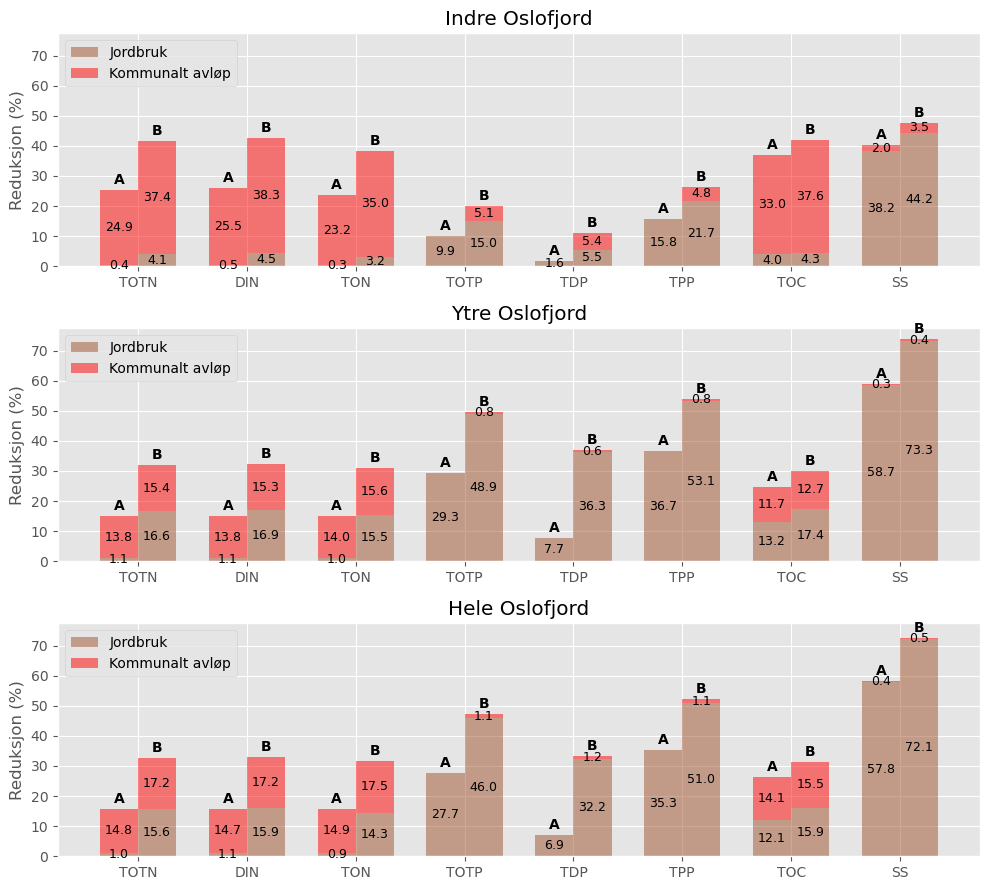

In [14]:
areas = df["area"].unique()
n_areas = len(areas)
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
fig, axes = plt.subplots(
    n_areas, 1, figsize=(10, 3 * n_areas), sharex=False, sharey=True
)
for ax, area in zip(axes, areas):
    area_df = df[df["area"] == area]
    scenarios = area_df["scenario"].unique()

    for i, par in enumerate(pars):
        for j, scenario in enumerate(scenarios):
            subset = area_df[
                (area_df["par"] == par) & (area_df["scenario"] == scenario)
            ]
            if not subset.empty:
                agri_val = subset["agri"].values[0]
                ww_val = subset["ww"].values[0]
                total = agri_val + ww_val
                x = i + j * 0.35

                # Plot bars
                ax.bar(
                    x,
                    agri_val,
                    width=0.35,
                    label="Jordbruk" if i == 0 and j == 0 else "",
                    color="sienna",
                    alpha=0.5,
                )
                ax.bar(
                    x,
                    ww_val,
                    bottom=agri_val,
                    width=0.35,
                    label="Kommunalt avløp" if i == 0 and j == 0 else "",
                    color="red",
                    alpha=0.5,
                )

                # Add percentage labels
                if agri_val > 0:
                    ax.text(
                        x,
                        agri_val / 2,
                        f"{agri_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )
                if ww_val > 0:
                    ax.text(
                        x,
                        agri_val + ww_val / 2,
                        f"{ww_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )

                # Add scenario label at top
                ax.text(
                    x,
                    total + 1,
                    # f"{scenario.split('_')[1]}\n{agri_val + ww_val:.1f}",
                    scenario.split("_")[1],
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    fontweight="bold",
                )

    ax.set_title(area)
    ax.set_ylabel("Reduksjon (%)")
    ax.set_xticks([i + 0.35 / 2 for i in range(len(pars))])
    ax.set_xticklabels(pars)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig(
    r"../plots/scen_change_raw_inputs_rel_to_anthrop_baseline.png",
    dpi=200,
    bbox_inches="tight",
)

## 5. Changes in delivery to the Oslofjord

### 5.1. Relative to the anthropogenic baseline

Changes in inputs to the fjord (i.e. including transport and retention), expressed relative to the anthropogenic baseline.

In [15]:
areas = [
    "Indre Oslofjord",
    "Ytre Oslofjord",
    "Hele Oslofjord",
]
anth_srcs = [
    "Bebygd",
    "Industri",
    "Jordbruk",
    "Kommunalt avløp",
    "Spredt avløp",
    "Akvakultur",
]

csv_path = r"../data/results_summary.csv"
df = pd.read_csv(csv_path).query("(`Område` in @areas) and (Kilde in @anth_srcs)")

data = {
    "par": [],
    "area": [],
    "scenario": [],
    "agri": [],
    "ww": [],
}
for par in df["Parameter"].unique():
    for area in df["Område"].unique():
        # Get total baseline anthropogenic input
        base_tot = df.query(
            "(Scenario == 'Baseline') and (Parameter == @par) and (`Område` == @area)"
        )["Verdi (tonn)"].sum()
        base_agri_tot = df.query(
            "(Scenario == 'Baseline') and (Parameter == @par) and (`Område` == @area) and (Kilde == 'Jordbruk')"
        )["Verdi (tonn)"].sum()
        base_ww_tot = df.query(
            "(Scenario == 'Baseline') and (Parameter == @par) and (`Område` == @area) and (Kilde == 'Kommunalt avløp')"
        )["Verdi (tonn)"].sum()
        for scen in ["Scenario_A", "Scenario_B"]:
            scen_tot = df.query(
                "(Scenario == @scen) and (Parameter == @par) and (`Område` == @area)"
            )["Verdi (tonn)"].sum()
            scen_agri_tot = df.query(
                "(Scenario == @scen) and (Parameter == @par) and (`Område` == @area) and (Kilde == 'Jordbruk')"
            )["Verdi (tonn)"].sum()
            scen_ww_tot = df.query(
                "(Scenario == @scen) and (Parameter == @par) and (`Område` == @area) and (Kilde == 'Kommunalt avløp')"
            )["Verdi (tonn)"].sum()

            scen_pct = np.abs(100 * (scen_tot - base_tot) / base_tot)
            agri_pct = np.abs(100 * (scen_agri_tot - base_agri_tot) / base_tot)
            ww_pct = np.abs(100 * (scen_ww_tot - base_ww_tot) / base_tot)
            assert round(scen_pct, 2) == round(agri_pct + ww_pct, 2)

            data["par"].append(par.upper())
            data["area"].append(area)
            data["scenario"].append(scen)
            data["agri"].append(agri_pct)
            data["ww"].append(ww_pct)
df = pd.DataFrame(data)
df.head()

,par,area,scenario,agri,ww
0,DIN,Indre Oslofjord,Scenario_A,0.418712,26.743168
1,DIN,Indre Oslofjord,Scenario_B,3.744695,40.086288
2,DIN,Ytre Oslofjord,Scenario_A,1.147562,15.366465
3,DIN,Ytre Oslofjord,Scenario_B,16.480719,17.088073
4,DIN,Hele Oslofjord,Scenario_A,1.082960,16.374847


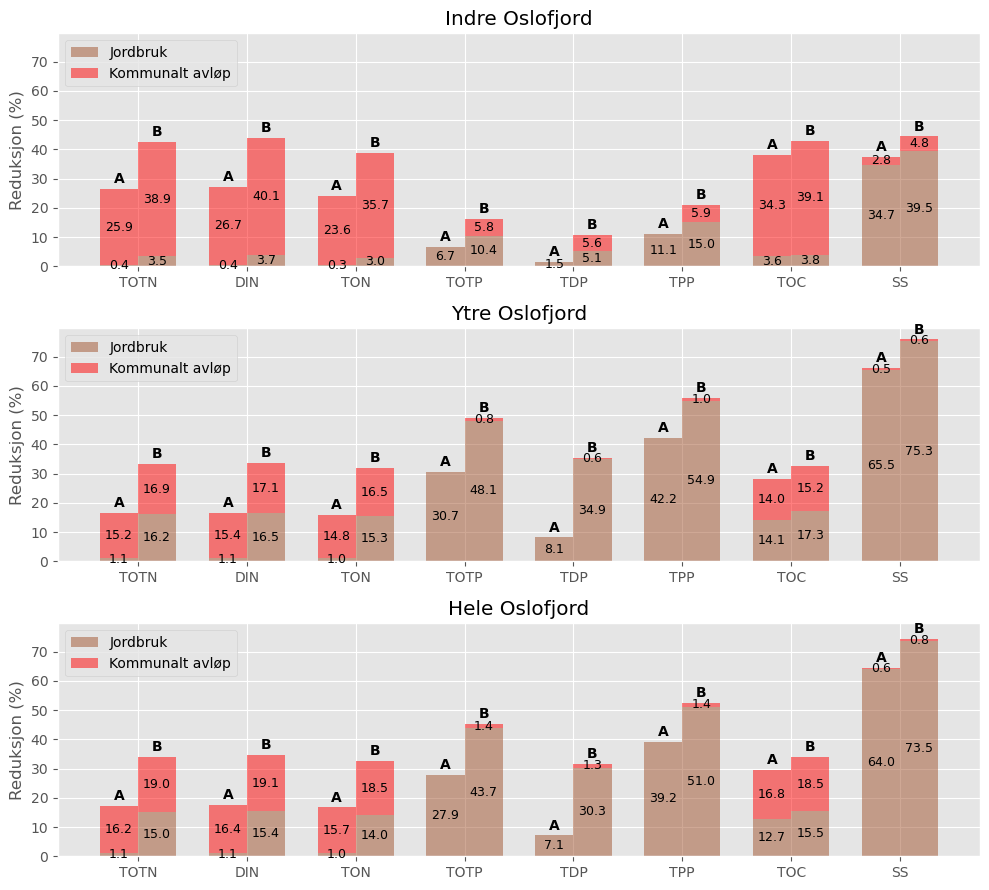

In [16]:
areas = df["area"].unique()
n_areas = len(areas)
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
fig, axes = plt.subplots(
    n_areas, 1, figsize=(10, 3 * n_areas), sharex=False, sharey=True
)
for ax, area in zip(axes, areas):
    area_df = df[df["area"] == area]
    scenarios = area_df["scenario"].unique()

    for i, par in enumerate(pars):
        for j, scenario in enumerate(scenarios):
            subset = area_df[
                (area_df["par"] == par) & (area_df["scenario"] == scenario)
            ]
            if not subset.empty:
                agri_val = subset["agri"].values[0]
                ww_val = subset["ww"].values[0]
                total = agri_val + ww_val
                x = i + j * 0.35

                # Plot bars
                ax.bar(
                    x,
                    agri_val,
                    width=0.35,
                    label="Jordbruk" if i == 0 and j == 0 else "",
                    color="sienna",
                    alpha=0.5,
                )
                ax.bar(
                    x,
                    ww_val,
                    bottom=agri_val,
                    width=0.35,
                    label="Kommunalt avløp" if i == 0 and j == 0 else "",
                    color="red",
                    alpha=0.5,
                )

                # Add percentage labels
                if agri_val > 0:
                    ax.text(
                        x,
                        agri_val / 2,
                        f"{agri_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )
                if ww_val > 0:
                    ax.text(
                        x,
                        agri_val + ww_val / 2,
                        f"{ww_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )

                # Add scenario label at top
                ax.text(
                    x,
                    total + 1,
                    # f"{scenario.split('_')[1]}\n{agri_val + ww_val:.1f}",
                    scenario.split("_")[1],
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    fontweight="bold",
                )

    ax.set_title(area)
    ax.set_ylabel("Reduksjon (%)")
    ax.set_xticks([i + 0.35 / 2 for i in range(len(pars))])
    ax.set_xticklabels(pars)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig(
    r"../plots/scen_change_oslofjord_inputs_rel_to_anthrop_baseline.png",
    dpi=200,
    bbox_inches="tight",
)

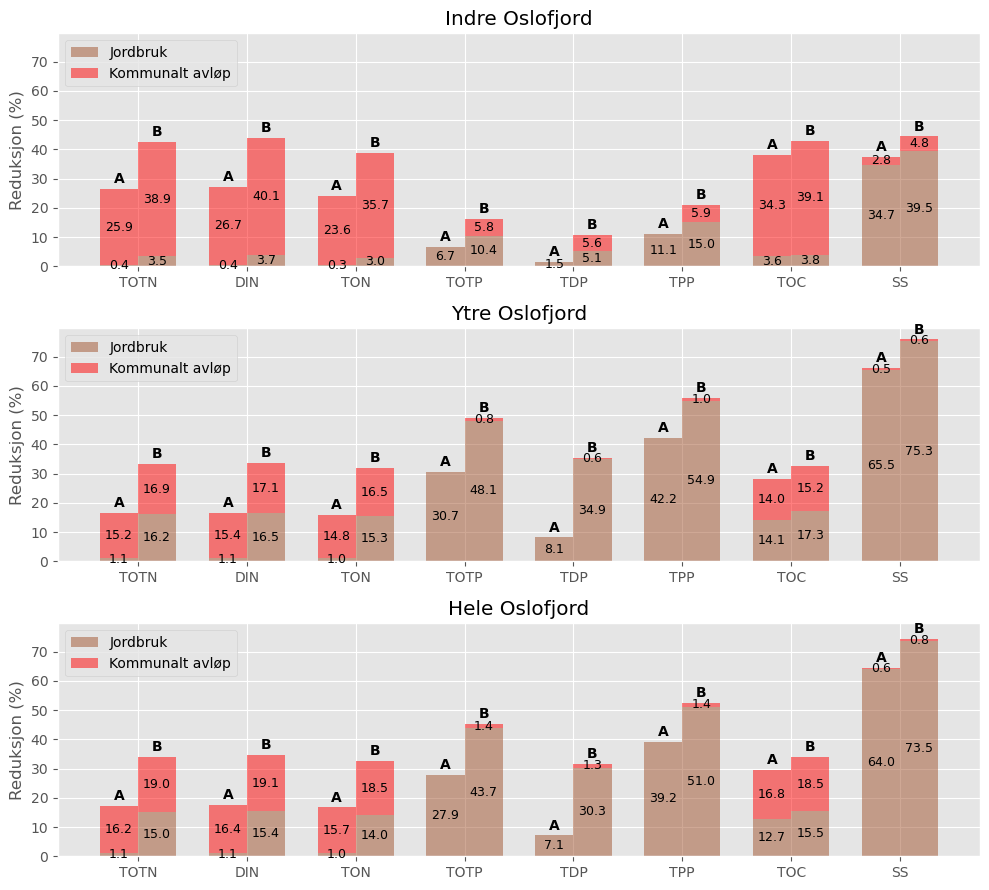

In [17]:
areas = df["area"].unique()
n_areas = len(areas)
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
fig, axes = plt.subplots(
    n_areas, 1, figsize=(10, 3 * n_areas), sharex=False, sharey=True
)
for ax, area in zip(axes, areas):
    area_df = df[df["area"] == area]
    scenarios = area_df["scenario"].unique()

    for i, par in enumerate(pars):
        for j, scenario in enumerate(scenarios):
            subset = area_df[
                (area_df["par"] == par) & (area_df["scenario"] == scenario)
            ]
            if not subset.empty:
                agri_val = subset["agri"].values[0]
                ww_val = subset["ww"].values[0]
                total = agri_val + ww_val
                x = i + j * 0.35

                # Plot bars
                ax.bar(
                    x,
                    agri_val,
                    width=0.35,
                    label="Jordbruk" if i == 0 and j == 0 else "",
                    color="sienna",
                    alpha=0.5,
                )
                ax.bar(
                    x,
                    ww_val,
                    bottom=agri_val,
                    width=0.35,
                    label="Kommunalt avløp" if i == 0 and j == 0 else "",
                    color="red",
                    alpha=0.5,
                )

                # Add percentage labels
                if agri_val > 0:
                    ax.text(
                        x,
                        agri_val / 2,
                        f"{agri_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )
                if ww_val > 0:
                    ax.text(
                        x,
                        agri_val + ww_val / 2,
                        f"{ww_val:.1f}",
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                    )

                # Add scenario label at top
                ax.text(
                    x,
                    total + 1,
                    # f"{scenario.split('_')[1]}\n{agri_val + ww_val:.1f}",
                    scenario.split("_")[1],
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    fontweight="bold",
                )

    ax.set_title(area)
    ax.set_ylabel("Reduksjon (%)")
    ax.set_xticks([i + 0.35 / 2 for i in range(len(pars))])
    ax.set_xticklabels(pars)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig(
    r"../plots/scen_change_oslofjord_inputs_rel_to_baseline_all_sources.png",
    dpi=200,
    bbox_inches="tight",
)

## 6. Wastewater sites affected by scenarios

In [18]:
cols = [
    "anlegg_nr",
    "year",
    "kilderefnr",
    "anlegg_name",
    "site_zone",
    "site_east",
    "site_north",
    "outlet_zone",
    "outlet_east",
    "outlet_north",
    "current_capacity",
]
df_list = []
for year in range(2017, 2020):
    xl_path = f"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_input_files/Baseline/{year}/large_wastewater_{year}_raw.xlsx"
    df = pd.read_excel(xl_path)[cols]
    df_list.append(df)

df = pd.concat(df_list, axis="rows")

# Get the max capacity reported for each site over all years
df = df.sort_values(by="current_capacity", ascending=False)
df = df.drop_duplicates(subset="anlegg_nr", keep="first")

# Just sites >= 1000 p.e.
df = df.query("current_capacity >= 1000")

# Assign categories
bins = [0, 999, 4999, 9999, float("inf")]
labels = ["< 1000", "1000 til 4999", "5000 til 9999", "≥ 10 000"]
df["Kapasitet (p.e.)"] = pd.cut(
    df["current_capacity"], bins=bins, labels=labels, right=True
)

# Build gdf and clip to Oslofjord
df["outlet_zone"] = df["outlet_zone"].astype(int)
df = nivapy.spatial.utm_to_wgs84_dd(
    df, zone="outlet_zone", east="outlet_east", north="outlet_north"
)
gdf = (
    gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="epsg:4326",
    )
    .to_crs("epsg:25833")
    .clip(cat_gdf)
)

gdf.head()

,anlegg_nr,year,kilderefnr,anlegg_name,site_zone,site_east,site_north,outlet_zone,outlet_east,outlet_north,current_capacity,Kapasitet (p.e.),lat,lon,geometry
1318,4014.0058.01,2019,0815AL02,Stabbestad renseanlegg,32,522889,6523293,32,523182.0,6523609.0,2313,1000 til 4999,58.851705,9.401775,POINT (177226.515 6537051.311)
1320,4014.0085.01,2019,0815AL51,Kirkesund renseanlegg,32,529417,6525546,32,529041.0,6525917.0,1862,1000 til 4999,58.872076,9.503616,POINT (183276.239 6538827.383)
1326,4014.0125.01,2018,0815AL01,Kragerø renseanlegg,32,523910,6526040,32,524056.0,6525989.0,15000,≥ 10 000,58.873030,9.417179,POINT (178311.582 6539346.349)
1275,4014.0035.01,2017,0815AL38,Kil renseanlegg,32,517400,6528100,32,517800.0,6527050.0,1992,1000 til 4999,58.882864,9.308775,POINT (172167.907 6540965.702)
1276,4014.0036.01,2017,0815AL08,Helle renseanlegg,32,521631,6528895,32,521800.0,6528800.0,1506,1000 til 4999,58.898395,9.378332,POINT (176314.005 6542352.006)


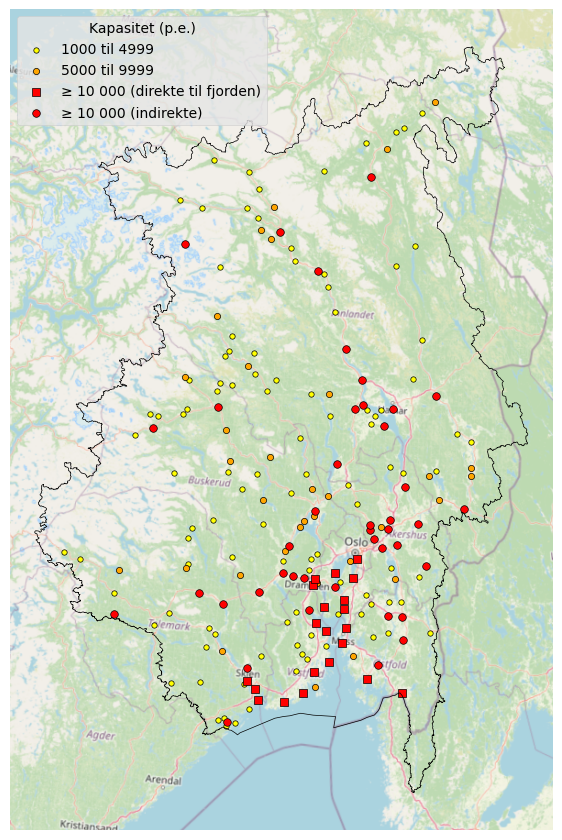

In [19]:
direct_df = pd.read_csv(r"../data/of800_wwtp_direct_to_oslofjord.csv").query(
    "`max_capacity_2017-19` >= 10000"
)
direct_list = direct_df["anlegg_nr"].unique().tolist()
style_map = {
    "1000 til 4999": {"size": 15, "color": "yellow"},
    "5000 til 9999": {"size": 20, "color": "orange"},
    "≥ 10 000": {"size": 30, "color": "red"},
}
fig, ax = plt.subplots(figsize=(7, 12))

# Plot all categories except "≥ 10 000"
for category, style in style_map.items():
    if category != "≥ 10 000":
        subset = gdf[gdf["Kapasitet (p.e.)"] == category]
        subset.plot(
            ax=ax,
            markersize=style["size"],
            color=style["color"],
            edgecolor="black",
            linewidth=0.5,
            label=category,
        )

# Direct and indirect for "≥ 10 000"
subset_10000 = gdf[gdf["Kapasitet (p.e.)"] == "≥ 10 000"]
subset_direct = subset_10000[subset_10000["anlegg_nr"].isin(direct_list)]
subset_indirect = subset_10000[~subset_10000["anlegg_nr"].isin(direct_list)]

# Plot direct
subset_direct.plot(
    ax=ax,
    markersize=style_map["≥ 10 000"]["size"],
    color=style_map["≥ 10 000"]["color"],
    edgecolor="black",
    linewidth=0.5,
    marker="s",
    label="≥ 10 000 (direkte til fjorden)",
)

# Plot indirect
subset_indirect.plot(
    ax=ax,
    markersize=style_map["≥ 10 000"]["size"],
    color=style_map["≥ 10 000"]["color"],
    edgecolor="black",
    linewidth=0.5,
    marker="o",
    label="≥ 10 000 (indirekte)",
)
cat_gdf.plot(ax=ax, color="none", edgecolor="black")
cx.add_basemap(
    ax=ax,
    crs=gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)
ax.axis("off")
ax.legend(title="Kapasitet (p.e.)", loc="upper left")

plt.savefig(
    r"../plots/oslofjord_wwtp_by_size.png",
    dpi=200,
    bbox_inches="tight",
)